In [2]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data = pd.read_csv("Iris.csv")

X = data.drop(columns=["Id", "Species"]).values
y = data["Species"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
class Node:
    def __init__(self, feature_idx=None, threshold=None, info_gain=None, left=None, right=None, value=None):

        # Decision Node
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.info_gain = info_gain
        self.left = left
        self.right = right

        # Leaf Node
        self.value = value

In [5]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=2):

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape

        if n_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.best_split(dataset, n_features)

            if best_split["info_gain"] > 0:
                left_node = self.build_tree(best_split["left_dataset"], curr_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], curr_depth + 1)

                return Node(best_split["feature_idx"], best_split["threshold"], best_split["info_gain"], left_node, right_node)
            
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    
    def best_split(self, dataset, n_features):
        best_split = {'feature_idx': None, 'threshold': None, 'info_gain': -1, 'left_dataset': None, 'right_dataset': None}

        for feature_idx in range(n_features):
            feature_values = dataset[:, feature_idx]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                left_dataset, right_dataset = self.split(dataset, feature_idx, threshold)

                if len(left_dataset) and len(right_dataset):
                    parent_y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]

                    info_gain = self.information_gain(parent_y, left_y, right_y)

                    if info_gain > best_split['info_gain']:
                        best_split['feature_idx'] = feature_idx
                        best_split['threshold'] = threshold
                        best_split['info_gain'] = info_gain
                        best_split['left_dataset'] = left_dataset
                        best_split['right_dataset'] = right_dataset

        return best_split
    
    def split(self, dataset, feature_idx, threshold):
        left_dataset = np.array([row for row in dataset if row[feature_idx] <= threshold])
        right_dataset = np.array([row for row in dataset if row[feature_idx] > threshold])

        return left_dataset, right_dataset
    
    def information_gain(self, parent_y, left_y, right_y):
        left_weight = len(left_y) / len(parent_y)
        right_weight = len(right_y) / len(parent_y)

        information_gain = self.entropy(parent_y) - (left_weight * self.entropy(left_y) + right_weight * self.entropy(right_y))
        return information_gain
    
    def entropy(self, y):
        entropy = 0

        class_labels = np.unique(y)
        for class_label in class_labels:
            p = len(y[y == class_label]) / len(y)
            entropy += -p * np.log2(p)
        
        return entropy
    
    def fit(self, X, y):
        dataset = np.concatenate([X, y.reshape(-1, 1)], axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        predictions = [self.predict_class(row, self.root) for row in X]
        return predictions
    
    def predict_class(self, row, node):
        if node.value != None:
            return node.value
        
        feature_val = row[node.feature_idx]
        if feature_val <= node.threshold:
            return self.predict_class(row, node.left)
        else:
            return self.predict_class(row, node.right)


In [6]:
def plot_tree(root):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis("off")

    def draw_node(node, x, y, dx):
        if node.value is not None:
            ax.text(x, y, f"Class: {node.value}",
                    ha="center", va="center",
                    bbox=dict(boxstyle="round", fc="lightgreen"))
            return

        label = f"X[{node.feature_idx}] ≤ {node.threshold:.2f}\nIG={node.info_gain:.3f}"
        ax.text(x, y, label,
                ha="center", va="center",
                bbox=dict(boxstyle="round", fc="lightblue"))

        if node.left:
            ax.plot([x, x - dx], [y - 0.1, y - 0.3], "k-")
            draw_node(node.left, x - dx, y - 0.3, dx / 2)

        if node.right:
            ax.plot([x, x + dx], [y - 0.1, y - 0.3], "k-")
            draw_node(node.right, x + dx, y - 0.3, dx / 2)

    draw_node(root, x=0.5, y=0.9, dx=0.2)
    plt.show()


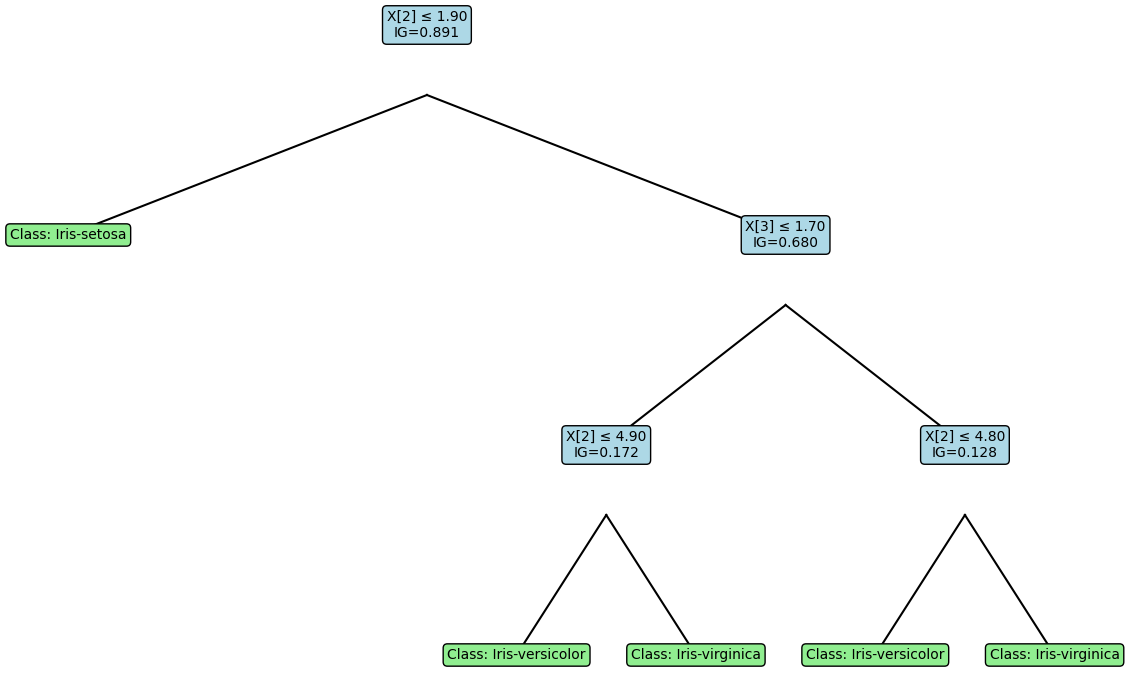

Accuracy: 96.67%


In [7]:
dt = DecisionTree(min_samples_split=2, max_depth=2)
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
plot_tree(dt.root)



accuracy = np.mean(predictions == y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")

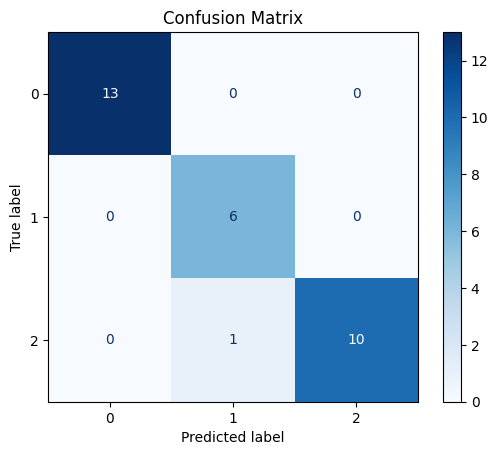

In [8]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

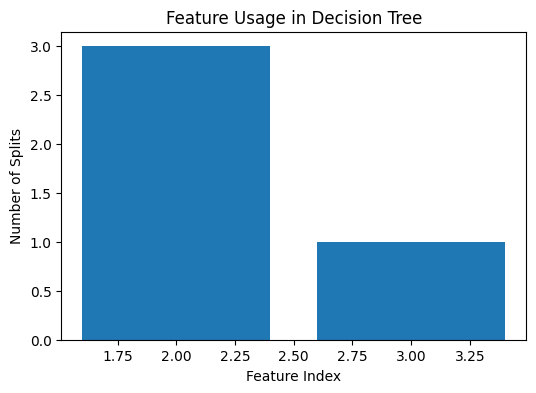

In [9]:
def feature_usage(node, counter):
    if node is None or node.value is not None:
        return

    counter[node.feature_idx] += 1
    feature_usage(node.left, counter)
    feature_usage(node.right, counter)


feature_counter = Counter()
feature_usage(dt.root, feature_counter)

features = list(feature_counter.keys())
counts = list(feature_counter.values())

plt.figure(figsize=(6, 4))
plt.bar(features, counts)
plt.xlabel("Feature Index")
plt.ylabel("Number of Splits")
plt.title("Feature Usage in Decision Tree")
plt.show()

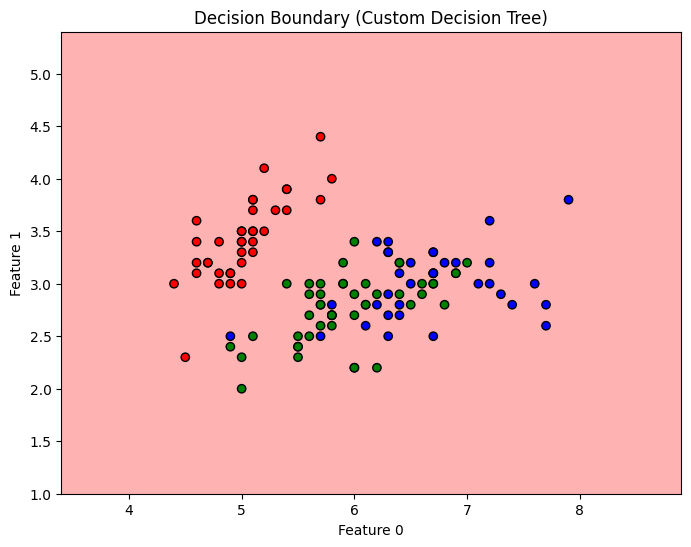

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


X_vis = X_train[:, :2]
y_vis = y_train


classes = np.unique(y_train)
class_to_int = {label: idx for idx, label in enumerate(classes)}

y_vis_num = np.array([class_to_int[y] for y in y_vis])


x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)


grid = np.c_[xx.ravel(), yy.ravel()]
grid_full = np.zeros((grid.shape[0], X_train.shape[1]))
grid_full[:, :2] = grid


Z = dt.predict(grid_full)
Z = np.array([class_to_int[z] for z in Z])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(
    xx, yy, Z,
    alpha=0.3,
    cmap=ListedColormap(["red", "green", "blue"])
)

plt.scatter(
    X_vis[:, 0],
    X_vis[:, 1],
    c=y_vis_num,
    edgecolor="k",
    cmap=ListedColormap(["red", "green", "blue"])
)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Decision Boundary (Custom Decision Tree)")
plt.show()
